In [63]:
# import libraries for data merging and visualization
import numpy as np
import datetime as dt
from datetime import timedelta
import pandas as pd
from pandas.tseries.offsets import MonthBegin
import sqlite3
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [64]:
# import stock return data
DSP = pd.read_csv('Data/DailyStockPrice.csv', parse_dates=['date'])
# DSP.head()
# DSP.info()

In [65]:
# import firm fiscal year data
FYear = pd.read_csv('Data/FiscalYear.csv', parse_dates=['datadate'])
FYear['begdate'] = FYear['datadate']- timedelta(days=365) + MonthBegin(0)
# FYear[['tic','fyear','begdate','datadate']].tail()

In [66]:
# use sql query to merge FYear data with DSP data
sqlconn = sqlite3.connect(':memory:')
FYear.to_sql('FYear',sqlconn)
DSP.to_sql('DSP', sqlconn,)

qry = '''
     SELECT
    a.tic, a.fyear, a.begdate, a.datadate, b.date, b.RETX, b.TICKER
    FROM FYear as a 
    LEFT JOIN DSP as b
    ON a.tic = b.TICKER
    AND a.begdate <= b.date 
    AND b.date <= a.datadate
    ORDER BY tic, datadate, date
    '''

FYear_DSP = pd.read_sql_query(qry, sqlconn)
# FYear_DSP.info()

In [67]:
# clean FYear_DSP data
FYear_DSP_v2 = FYear_DSP.drop(columns=['tic'])
# FYear_DSP_v2.head()

FYear_DSP_v3 = FYear_DSP_v2.groupby(['TICKER','fyear'], as_index=False)['RETX'].mean()
FYear_DSP_v3.rename(columns={'RETX':'avg_prc', 'TICKER':'Ticker', 'fyear':'FiscalYear'}, inplace=True)
# FYear_DSP_v3.tail(10)

In [68]:
# import firm pay ratio data
PayRatio = pd.read_excel('Data/Full_Pay_Ratio.xlsx', parse_dates=['FilingDate'])
# PayRatio.head()

In [69]:
# merge PayRatio data with FYear_DSP_v3 data
Merge1 = pd.merge(PayRatio, FYear_DSP_v3, how='left', on=['Ticker','FiscalYear'])
# Merge1.head(20)

In [70]:
# clean merged data
Merge1 = Merge1.dropna()
# Merge1.shape

In [71]:
# import Book to Market and MktCap data
BMC = pd.read_csv('Data/BMC.csv', parse_dates=['datadate'])
# BMC.head()

In [72]:
# merge BMC data with Merge1 data
Merge2 = pd.merge(Merge1, BMC, how='left', on=['Ticker','FiscalYear'])
# Merge2.head()

In [73]:
# clean Merge2 data
Merge3 = Merge2.drop(columns=['No','CIK','FilingDate', 'gvkey', 'datadate','popsrc','datafmt','conm','curcd','fyr', 'consol','costat','indfmt','Book Value Per Share','Price Close - Annual - Fiscal'])
# Merge3.head()

In [74]:
# further cleaning of the merged data
Merge4 = Merge3.dropna()
Merge4 = Merge4[Merge4['PayRatio'] !=0]
Merge4 = Merge4[Merge4['avg_prc'] !=0]
# Merge4.tail(20)

In [75]:
# transform PayRatio and MktCap data for analysis
Merge4['lnPayRatio'] = np.log(Merge4['PayRatio'])
Merge4['lnMktCap'] = np.log(Merge4['MktCap'])

In [76]:
# export the merged data as a .csv
df_FinalMerge = pd.DataFrame(Merge4)
df_FinalMerge.to_csv('Data/PayRatio_BMC_DSP_Merged.csv', index=False)

Coefficient of Determination: 0.0007312857342266499
Intercept: [0.00043319]
Slope: [[3.36788498e-05]]


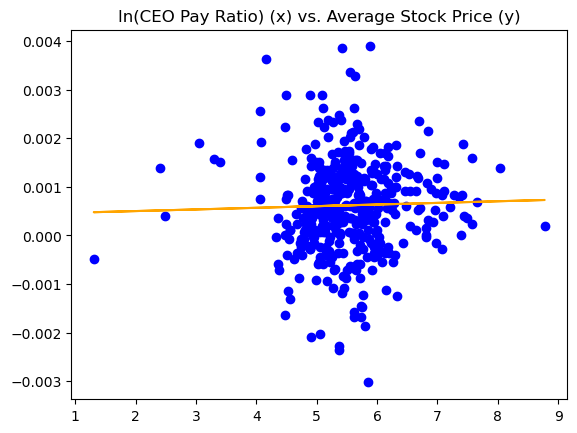

In [77]:
# visualization
df_binary = Merge4[['lnPayRatio', 'avg_prc']]
df_binary.columns = ['ln(Pay Ratio)', 'Avg. Prc.']
# df_binary.head()

x = np.array(df_binary['ln(Pay Ratio)']).reshape(-1, 1)
y = np.array(df_binary['Avg. Prc.']).reshape(-1, 1)

model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)
print(f"Coefficient of Determination: {r_sq}")
print(f"Intercept: {model.intercept_}")
print(f"Slope: {model.coef_}")

y_regr = np.array([model.coef_ * i + model.intercept_ for i in x]).reshape(-1, 1)

plt.title('ln(CEO Pay Ratio) (x) vs. Average Stock Price (y)')
plt.scatter(x, y, color='blue')
plt.plot(x, y_regr, color='orange')
plt.show()

Coefficient of Determination: 0.010023341688506715
Intercept: [11.20588442]
Slope: [[0.10071106]]


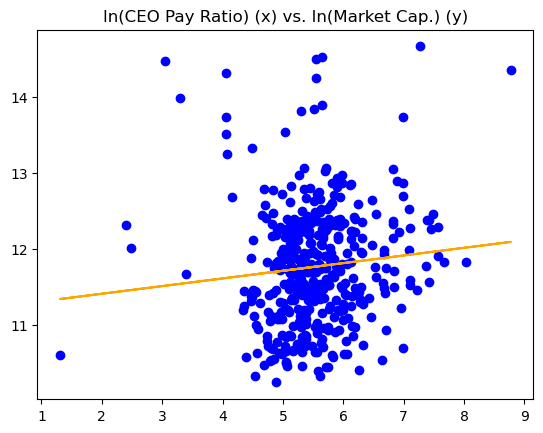

In [79]:
df_binary = Merge4[['lnPayRatio', 'lnMktCap']]
df_binary.columns = ['ln(Pay Ratio)', 'ln(Market Cap.)']
# df_binary.head()

x = np.array(df_binary['ln(Pay Ratio)']).reshape(-1, 1)
y = np.array(df_binary['ln(Market Cap.)']).reshape(-1, 1)

model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)
print(f"Coefficient of Determination: {r_sq}")
print(f"Intercept: {model.intercept_}")
print(f"Slope: {model.coef_}")

y_regr = np.array([model.coef_ * i + model.intercept_ for i in x]).reshape(-1, 1)

plt.title('ln(CEO Pay Ratio) (x) vs. ln(Market Cap.) (y)')
plt.scatter(x, y, color='blue')
plt.plot(x, y_regr, color='orange')
plt.show()

Coefficient of Determination: 0.018583632761762114
Intercept: [0.63269952]
Slope: [[-0.05725957]]


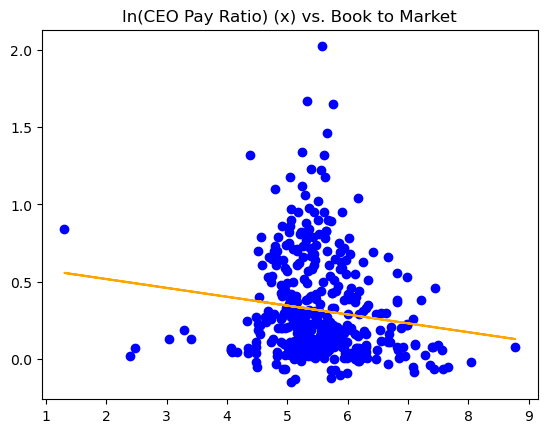

In [80]:
df_binary = Merge4[['lnPayRatio', 'BookToMarket']]
df_binary.columns = ['ln(Pay Ratio)', 'Book to Market']
# df_binary.head()

x = np.array(df_binary['ln(Pay Ratio)']).reshape(-1, 1)
y = np.array(df_binary['Book to Market']).reshape(-1, 1)

model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)
print(f"Coefficient of Determination: {r_sq}")
print(f"Intercept: {model.intercept_}")
print(f"Slope: {model.coef_}")

y_regr = np.array([model.coef_ * i + model.intercept_ for i in x]).reshape(-1, 1)

plt.title('ln(CEO Pay Ratio) (x) vs. Book to Market')
plt.scatter(x, y, color='blue')
plt.plot(x, y_regr, color='orange')
plt.show()

Coefficient of Determination: 0.010906054637797813
Intercept: [-69704.73946516]
Slope: [[34.69837149]]


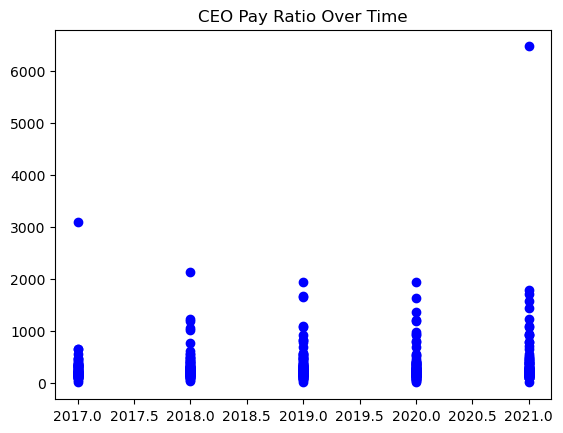

In [82]:
df_binary = Merge4[['FiscalYear', 'PayRatio']]
df_binary.columns = ['Fiscal Year', 'CEO Pay Ratio']
# df_binary.head()

x = np.array(df_binary['Fiscal Year']).reshape(-1, 1)
y = np.array(df_binary['CEO Pay Ratio']).reshape(-1, 1)

model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)
print(f"Coefficient of Determination: {r_sq}")
print(f"Intercept: {model.intercept_}")
print(f"Slope: {model.coef_}")

y_regr = np.array([model.coef_ * i + model.intercept_ for i in x]).reshape(-1, 1)

plt.title('CEO Pay Ratio Over Time')
plt.scatter(x, y, color='blue')
# plt.plot(x, y_regr, color='orange')
plt.show()